In [4]:
# -*- coding: utf-8 -*-

#@author:yangsong
import re
import networkx as nx
import time
from lxml import etree
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
#获取北京地铁线路
def get_subway_lines():
    subways = {}
    url='http://www.bjsubway.com/e/action/ListInfo/?classid=39&ph=1'
    html=etree.parse(url, etree.HTMLParser())
    tables=html.xpath('//div[@class="line_place"]/div/table')
    for t in tables:
        linename=t.xpath('./thead/tr[1]/td/text()')#获取地铁线名称
        linename=re.sub(r'[首末车时刻表 \r\n' ']+','',linename[0]) #处理字符
        stations=t.xpath('./tbody/tr/th[1]/text()')#获取对应站点名称
        stations=[s.strip() for s in stations]
        subways[linename]=stations
    return subways

In [25]:
#获得站点关联关系
def get_connection(bj_subway):
    dicts=defaultdict(list)
    for line,stations in bj_subway.items():
        #取相邻两站名称
        for k,v in enumerate(stations):
            if k>0 and k<len(stations)-1: #中间站
                dicts[v].append(stations[k-1])
                dicts[v].append( stations[k+1])
            elif k==0: #起始站
                dicts[v].append(stations[k+1])
            else: #终点站
                dicts[v].append(stations[k-1])
    return dicts
#获得站点线路所属关系
def get_station_line():
    station_line = defaultdict(list)
    for line, station in bj_subway.items():
        for s in station:
            station_line[s].append(line)
    return station_line

#获得换乘次数
def get_change_times(path):
    station_line = get_station_line()
    lines_list=[]
    i=0 #换乘次数
    for p in path:lines_list.append(station_line[p][0])
    for x,y in enumerate(lines_list):
        if x<(len(lines_list)-1) and y!=lines_list[x+1]: i+=1
    return i

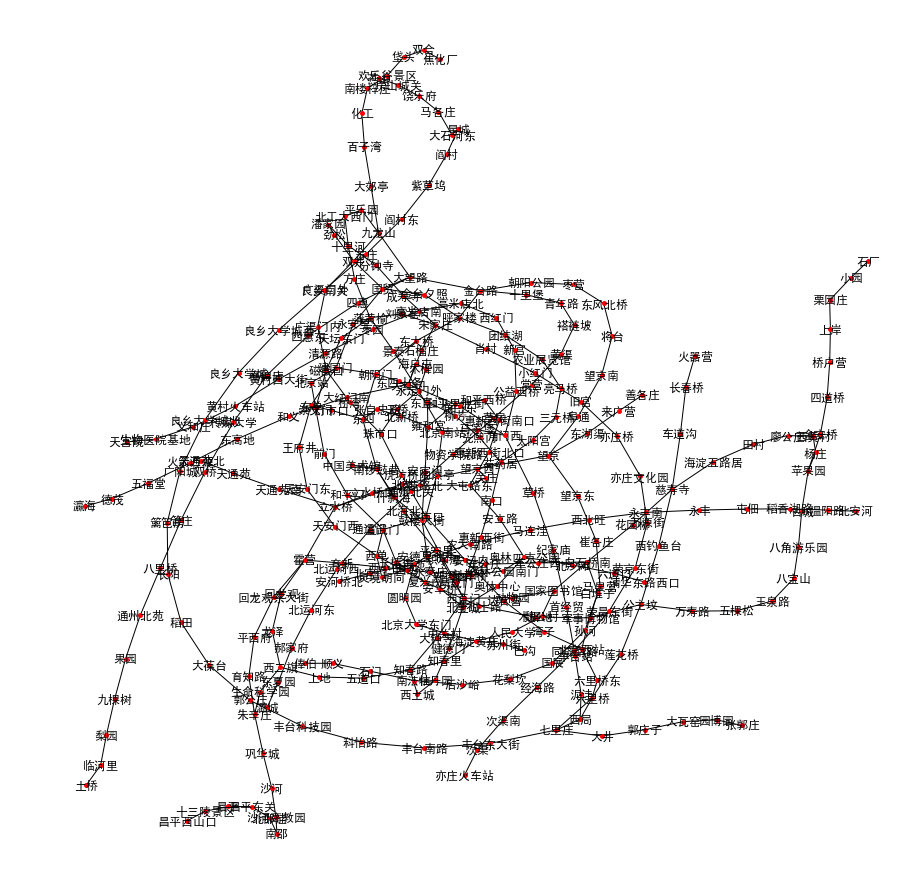

In [19]:
bj_subway=get_subway_lines()
connections=get_connection(bj_subway)
subway_graph=nx.Graph(connections)#初始化数据
plt.figure(3,figsize=(12,12))#设置图片大小
nx.draw(subway_graph, pos=nx.spring_layout(subway_graph), with_labels=True, node_size=15)

In [20]:
#路程最短
def shortest_priority(start,destination,by_way=None):
    station_line=defaultdict(list)
    for line,station in bj_subway.items():
        for s in station:
            station_line[s].append(line)
    pathes=[[start]]
    shortest=float('inf')
    new_path_list=[]
    shortest_path=[]
    while pathes:
        path=pathes.pop(0)
        frontier=path[-1]
        if len(path) >= shortest:continue #小于当前最小路径
        successors=connections[frontier]
        for station in successors:
            if station in path: continue #不重复站点
            new_path=path+[station]
            if station==destination:
                have_byway = [n for n in new_path if n in by_way]
                if have_byway==by_way:
                    shortest=len(new_path)
                    new_path_list.append(new_path)
            else:
                pathes.append(new_path)
    for path in enumerate(new_path_list):
        if shortest >=len(path):
            shortest_path.append(path[1])
    return shortest_path

In [21]:
shortest=shortest_priority('巩华城','立水桥',['牡丹园','安立路'])
print(shortest)

[['巩华城', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '安立路', '大屯路东', '北苑路北', '立水桥南', '立水桥']]


In [26]:
# 换乘最少
def minimum_transfer_priority(start,destination,by_way=None):
    station_line=defaultdict(list)
    for line,station in bj_subway.items():
        for s in station:
            station_line[s].append(line)
    pathes=[[start]]
    shortest=float('inf')
    new_path_list=[]
    shortest_path=[]
    while pathes:
        path=pathes.pop(0)
        lines=get_change_times(path)
        frontier=path[-1]
        if lines > shortest:continue #线路不大于当前最短线路
        successors=connections[frontier]
        for station in successors:
            if station in path : continue #不重复站点
            new_path=path+[station]
            if station==destination:
                have_byway = [n for n in new_path if n in by_way]
                if have_byway==by_way :
                    new=get_change_times(path)
                    shortest=new if new < shortest else  shortest
                    new_path_list.append(new_path)
            else:
                pathes.append(new_path)
    for path in new_path_list:
        path_length=get_change_times(path)
        if shortest >=path_length:
            shortest_path.append(path)
    return shortest_path

In [27]:
minimum_transfer=minimum_transfer_priority('巩华城','立水桥',['牡丹园','安立路'])
print(minimum_transfer)

[['巩华城', '朱辛庄', '育知路', '平西府', '回龙观东大街', '霍营', '回龙观', '龙泽', '西二旗', '上地', '五道口', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '安立路', '大屯路东', '北苑路北', '立水桥南', '立水桥']]


In [28]:
#综合优先
def  comprehensive_priority(start,destination,by_way):
    #以乘车时间为准最少为最优：
    #乘车时间=每站点消耗时间*站点数+换乘单位时间x换乘数，这里设定每站点消耗时间3分钟，换乘时间10分钟
    shortest=shortest_priority(start,destination,by_way)
    minimum_transfer=minimum_transfer_priority(start,destination,by_way)
    shortest.append(minimum_transfer[0])
    for path in shortest:
        station_time = len(path) * 3
        change_line_time = (get_change_times(path)) * 10
        path_time = station_time + change_line_time
        path.append(path_time)
    return [path[:-1] for path in shortest if path[-1]==min(shortest,key=lambda x:int(x[-1]))[-1]]

In [29]:
comprehensive=comprehensive_priority('巩华城','立水桥',['牡丹园','安立路'])
print(comprehensive)

[['巩华城', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '安立路', '大屯路东', '北苑路北', '立水桥南', '立水桥']]
